# TME 7: Approches par modèles de substitution

- LE LORIER Yann
- NGUYEN Hoang-Son

In [1]:
import numpy as np
from decision_tree import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Exercise 1

### 1-2.

In [2]:
df_mushrooms = pd.read_csv('data/mushrooms-1124.csv')
X_train, X_test, y_train, y_test = train_test_split(df_mushrooms.drop('class', axis=1), df_mushrooms['class'], test_size=0.2)
tree_mushrooms = MonArbre()
tree_mushrooms.fit(X_train, y_train)

### 3.

In [3]:
np.random.seed(1)
id_rand = np.random.randint(len(y_test))
predict = X_test.iloc[id_rand]

In [4]:
from sklearn.preprocessing import OrdinalEncoder

input_enc = OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value', encoded_missing_value=-1)
output_enc = OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value', encoded_missing_value=-1 )

input_enc.fit(df_mushrooms.drop('class', axis=1).values)
output_enc.fit(df_mushrooms[['class']].values)

OrdinalEncoder(encoded_missing_value=-1, handle_unknown='use_encoded_value',
               unknown_value=-1)

In [5]:
X_train = input_enc.transform(df_mushrooms.drop('class', axis=1).values)
y_train = output_enc.transform(df_mushrooms[['class']].values)

X_test = input_enc.transform(df_mushrooms.drop('class', axis=1).values)
y_test = output_enc.transform(df_mushrooms[['class']].values)

In [6]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [7]:
accuracy_score(clf.predict(X_test), y_test)

1.0

In [8]:
def print_path():
    path_dict = {}
    
    node_indicator = clf.decision_path(X_test)
    leaf_id = clf.apply(X_test)
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    sample_id = 0
    # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
    node_index = node_indicator.indices[
        node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
    ]
    
    print("Rules used to predict sample {id}:\n".format(id=sample_id))
    for node_id in node_index:
        # continue to the next node if it is a leaf node
        if leaf_id[sample_id] == node_id:
            continue
    
        # check if value of the split feature for sample 0 is below threshold
        if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
            threshold_sign = "<="
        else:
            threshold_sign = ">"
    
        print(
            "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
            "{inequality} {threshold})".format(
                node=node_id,
                sample=sample_id,
                feature=feature[node_id],
                value=X_test[sample_id, feature[node_id]],
                inequality=threshold_sign,
                threshold=threshold[node_id],
            )
        )
    path_dict['node_indicator'] = node_indicator
    path_dict['leaf_id'] = leaf_id
    path_dict['feature'] = feature
    path_dict['threshold'] = threshold
    path_dict['sample_id'] = sample_id
    return path_dict

In [9]:
clf.predict([X_test[0]])

array([1.])

In [10]:
path_dict = print_path()

Rules used to predict sample 0:

decision node 0 : (X_test[0, 8] = 4.0) > 3.5)
decision node 12 : (X_test[0, 19] = 3.0) > 1.5)
decision node 16 : (X_test[0, 7] = 1.0) > 0.5)
decision node 28 : (X_test[0, 9] = 0.0) <= 0.5)
decision node 29 : (X_test[0, 2] = 8.0) > 3.5)
decision node 33 : (X_test[0, 1] = 3.0) > 0.5)


In [11]:
#Pour visualiser l'arbre avec graphviz en SVG
from graphviz import Source

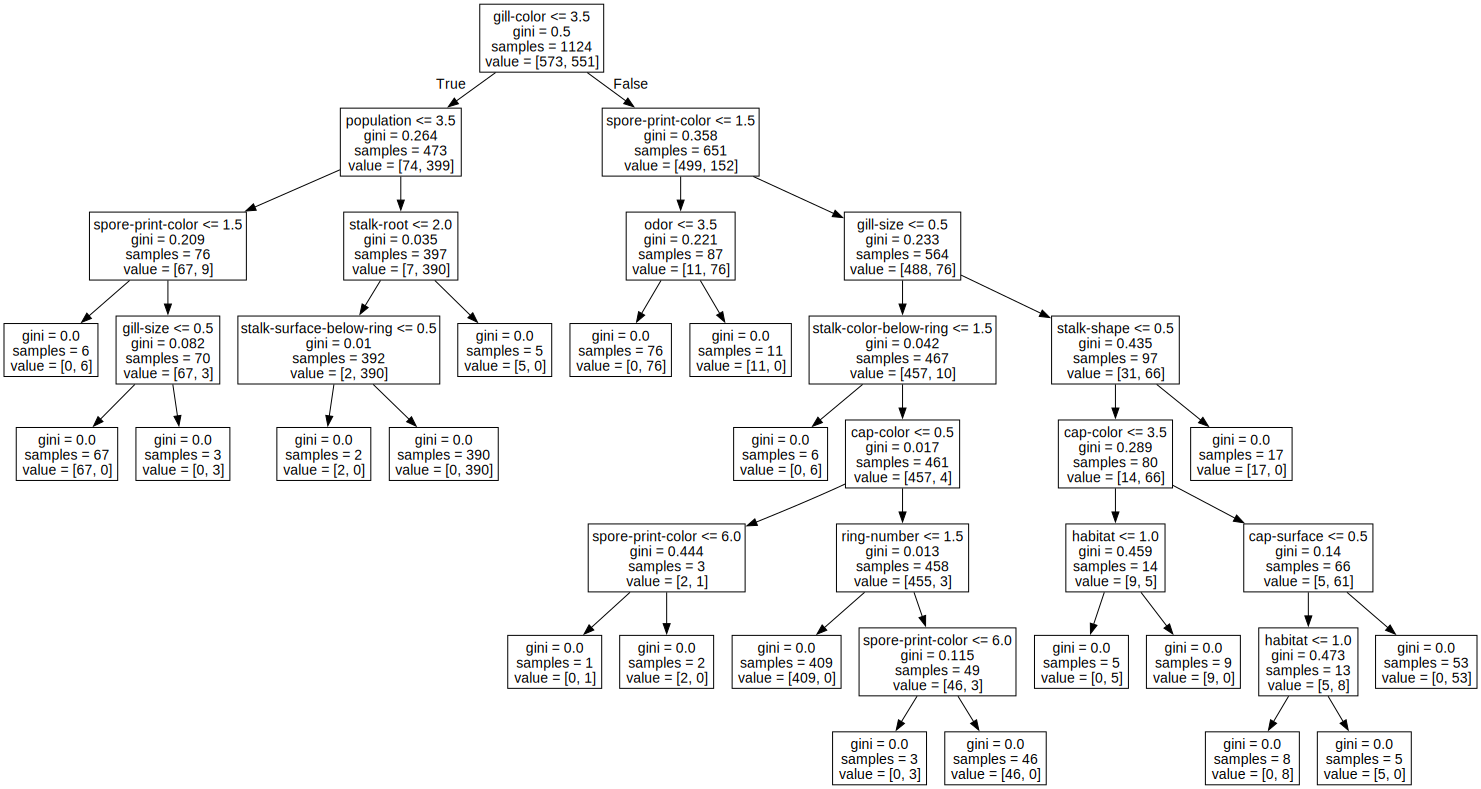

In [12]:
Source(export_graphviz(clf, out_file=None, feature_names=df_mushrooms.columns.drop('class')))

### 4. Règles contrefactuelles

Nous pouvons maintenant utiliser `path_dict` pour construire les règles contrefactuelles de manière exhaustive.

In [13]:
def print_counterfactual_rules(path_dict, clf):
    node_indicator = path_dict['node_indicator']
    sample_id = path_dict['sample_id']
    leaf_id = path_dict['leaf_id']
    threshold = path_dict['threshold']
    feature = path_dict['feature']

    # On obtient toutes les feuilles de l'arbre
    leaf_indices = np.where(clf.tree_.children_left == clf.tree_.children_right)[0]

    for leaf in leaf_indices:
        # obtain ids of the nodes `sample_id` goes through, i.e., row `leaf`
        node_index = node_indicator.indices[
            node_indicator.indptr[leaf] : node_indicator.indptr[leaf + 1]
        ]
    
        print("\n\n=======\nRules used to predict leaf {id}:\n".format(id=leaf))
        for node_id in node_index:
            # continue to the next node if it is a leaf node
            if leaf_id[leaf] == node_id:
                continue
        
            # check if value of the split feature for sample 0 is below threshold
            if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
                threshold_sign = "<="
            else:
                threshold_sign = ">"
        
            print(
                "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
                "{inequality} {threshold})".format(
                    node=node_id,
                    sample=sample_id,
                    feature=feature[node_id],
                    value=X_test[sample_id, feature[node_id]],
                    inequality=threshold_sign,
                    threshold=threshold[node_id],
                )
            )
        

In [14]:
print_counterfactual_rules(path_dict,clf)



Rules used to predict leaf 3:

decision node 0 : (X_test[0, 8] = 4.0) > 3.5)
decision node 1 : (X_test[0, 20] = 3.0) <= 3.5)
decision node 7 : (X_test[0, 10] = 3.0) > 2.0)
decision node 8 : (X_test[0, 12] = 2.0) > 0.5)


Rules used to predict leaf 5:

decision node 0 : (X_test[0, 8] = 4.0) > 3.5)
decision node 1 : (X_test[0, 20] = 3.0) <= 3.5)
decision node 7 : (X_test[0, 10] = 3.0) > 2.0)
decision node 8 : (X_test[0, 12] = 2.0) > 0.5)


Rules used to predict leaf 6:

decision node 0 : (X_test[0, 8] = 4.0) > 3.5)
decision node 1 : (X_test[0, 20] = 3.0) <= 3.5)
decision node 7 : (X_test[0, 10] = 3.0) > 2.0)
decision node 8 : (X_test[0, 12] = 2.0) > 0.5)


Rules used to predict leaf 9:

decision node 0 : (X_test[0, 8] = 4.0) > 3.5)
decision node 1 : (X_test[0, 20] = 3.0) <= 3.5)
decision node 7 : (X_test[0, 10] = 3.0) > 2.0)
decision node 8 : (X_test[0, 12] = 2.0) > 0.5)


Rules used to predict leaf 10:

decision node 0 : (X_test[0, 8] = 4.0) > 3.5)
decision node 12 : (X_test[0, 19] = 

### 5. Explication des règles

Pour $x$, l'explication se trouve par rapport aux valeurs prises pour l'exemple. Par exemple, quand l'habitat $\leq 1$, alors la classe est définie comme 1. Sinon, c'est une classe 0. C'est surtout ces attributs décisifs qui vont permettre de classifier l'exemple.

### 6. Méthode d'explication

Pour la classification binaire, nous allons tout d'abord déterminer quelle est la classe souhaitée par l'usager. Comme il y a plusieurs manières d'obtenir la même classe, nous pouvons obtenir toutes les feuilles de l'arbre qui mènent à la classe souhaitée.

## Exercice 2. Génération de bases d'apprentissages et d'explications

En nous basant fortement sur la méthode LORE, nous proposons l'algorithme suivant:

Nous allons donc créér une classe LORELike, fortement basée sur la proposition du papier par Guidotti _et al._. [Lien Arxiv](https://arxiv.org/abs/1805.10820)

De plus, nous pouvons recopier la fonction écrite auparavant `print_path` et `print_counterfactual_rules` pour les adapter à notre cas d'usage.

In [15]:
class LORELike():
    def __init__(self, clf, test_set):
        self.knowledge_base = None
        self.black_box = clf
        self.test_set = test_set
        self.xai_clf = None
        
    def crossover(self, pop_):
        """
        fonction de crossover entre deux éléments
        """
        #choix des parents
        # x est le parent1
        choice = np.random.choice(len(pop_), size=2, replace=False)
        x, parent2 = choice[0], choice[1]
        child1, child2 = x, parent2
        #choix des attributs
        idx_attr = (np.random.choice(len(pop_[x]), size=2, replace=False))
        for id in idx_attr:
            pop_[child1][id] = pop_[parent2][id]
            pop_[child2][id] = pop_[x][id]
        
        return pop_
    
    def mutate(self, pop_, rdm_choice):
        """
        Mutation d'un élément de la population
        """
        x_rdm = self.test_set[rdm_choice]
        to_mutate = np.random.choice(len(pop_))
        rng = np.random.default_rng()
        idx = rng.integers(0, len(pop_[to_mutate]), size=2)
        
        for id in idx:
            pop_[to_mutate][id] = x_rdm[id]
        return pop_
    
    def d(self, x,z):
        """
        Mesure de distance entre deux data points. Peut etre amelioré.
        """
        euclidean_distance = np.linalg.norm(x - z)
        n = len(x)
        normalized_distance = euclidean_distance / np.sqrt(n)
        return normalized_distance
    
    def fitness_same(self, x, z):
        I_class = int(self.black_box.predict(x).item() == self.black_box.predict(z).item())
        I_dpoint = int(np.all(x == z))
        return I_class + (1 - self.d(x,z)) - I_dpoint
    
    def fitness_diff(self, x, z):
        I_class = int(self.black_box.predict(x).item() != self.black_box.predict(z).item())
        I_dpoint = int(np.all(x==z))
        return I_class + (1 - self.d(x,z)) - I_dpoint

    def select_p_i(self, population, selection_size):
        new_pop_ind = np.random.choice(len(population), size=selection_size)
        return [population[i] for i in new_pop_ind], new_pop_ind

    def put_back(self, population, new_pop, new_pop_ind):
        for ind, value in zip(new_pop_ind, new_pop):
            population[ind] = value
        return population
        
    def build_knowledge_base(self, clf, x, to_gen=10, fitness=fitness_same, N=10, selection_size=2):
        assert selection_size <= N
        population = [x.copy() for _ in range(N)]
        
        for g in range(to_gen):
            new_pop, new_pop_ind = self.select_p_i(population, selection_size)
            
            new_pop = self.crossover(new_pop)
            population = self.put_back(population, new_pop, new_pop_ind)
            rdm_choice = np.random.choice(self.test_set.shape[0])
            new_pop, new_pop_ind = self.select_p_i(population, selection_size)
            new_pop = self.mutate(new_pop, rdm_choice)
            population = self.put_back(population, new_pop, new_pop_ind)
            fits = [fitness(x.reshape(1,-1), p.reshape(1,-1)) for p in new_pop]
            fits_argsorted = np.argsort(fits)
            new_pop = [new_pop[fa] for fa in range(selection_size)] + new_pop[selection_size:]
        return population

    def print_path(self, x, ind):
        """
        Cette fonction imprime les règles nécessaires pour classifier un exemple x
        """
        path_dict = {}
        
        node_indicator = self.xai_clf.decision_path(self.test_set)
        leaf_id = self.xai_clf.apply(self.test_set)
        feature = self.xai_clf.tree_.feature
        threshold = self.xai_clf.tree_.threshold
        sample_id = ind
        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
        ]
        
        print("Rules used to predict sample {id}:\n".format(id=sample_id))
        for node_id in node_index:
            # continue to the next node if it is a leaf node
            if leaf_id[sample_id] == node_id:
                continue
        
            # check if value of the split feature for sample 0 is below threshold
            if self.test_set[sample_id, feature[node_id]] <= threshold[node_id]:
                threshold_sign = "<="
            else:
                threshold_sign = ">"
        
            print(
                "decision node {node} : (test_set[{sample}, {feature}] = {value}) "
                "{inequality} {threshold})".format(
                    node=node_id,
                    sample=sample_id,
                    feature=feature[node_id],
                    value=X_test[sample_id, feature[node_id]],
                    inequality=threshold_sign,
                    threshold=threshold[node_id],
                )
            )
        path_dict['node_indicator'] = node_indicator
        path_dict['leaf_id'] = leaf_id
        path_dict['feature'] = feature
        path_dict['threshold'] = threshold
        path_dict['sample_id'] = sample_id
        return path_dict

    def print_counterfactual_rules(self, path_dict):
        node_indicator = path_dict['node_indicator']
        sample_id = path_dict['sample_id']
        leaf_id = path_dict['leaf_id']
        threshold = path_dict['threshold']
        feature = path_dict['feature']
    
        # On obtient toutes les feuilles de l'arbre
        leaf_indices = np.where(self.black_box.tree_.children_left == self.black_box.tree_.children_right)[0]
    
        for leaf in leaf_indices:
            # obtain ids of the nodes `sample_id` goes through, i.e., row `leaf`
            node_index = node_indicator.indices[
                node_indicator.indptr[leaf] : node_indicator.indptr[leaf + 1]
            ]
        
            print("\n\n=======\nRules used to predict leaf {id}:\n".format(id=leaf))
            for node_id in node_index:
                # continue to the next node if it is a leaf node
                if leaf_id[leaf] == node_id:
                    continue
            
                # check if value of the split feature for sample 0 is below threshold
                if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
                    threshold_sign = "<="
                else:
                    threshold_sign = ">"
            
                print(
                    "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
                    "{inequality} {threshold})".format(
                        node=node_id,
                        sample=sample_id,
                        feature=feature[node_id],
                        value=X_test[sample_id, feature[node_id]],
                        inequality=threshold_sign,
                        threshold=threshold[node_id],
                    )
                )
        
    def lore(self, x, ind):
        """
        Appel à l'algorithme principal
        """
        kb_same = self.build_knowledge_base(self.black_box, x, fitness=self.fitness_same)
        kb_diff = self.build_knowledge_base(self.black_box, x, fitness=self.fitness_diff)
        
        self.knowledge_base = kb_same + kb_diff
        self.xai_clf = DecisionTreeClassifier()
        y = self.black_box.predict(self.knowledge_base)
        self.xai_clf.fit(self.knowledge_base, y)
        path_dict = self.print_path(x, ind)
        self.print_counterfactual_rules(path_dict)

In [16]:
#Note: clf is the classifier we used before.
lore = LORELike(clf, X_test)
lore.lore(X_test[0], 10)

Rules used to predict sample 10:

decision node 0 : (test_set[10, 2] = 2.0) <= 5.5)


Rules used to predict leaf 3:

decision node 0 : (X_test[10, 2] = 2.0) <= 5.5)


Rules used to predict leaf 5:

decision node 0 : (X_test[10, 2] = 2.0) <= 5.5)
decision node 2 : (X_test[10, 4] = 5.0) <= 6.5)
decision node 3 : (X_test[10, 3] = 1.0) > 0.5)


Rules used to predict leaf 6:

decision node 0 : (X_test[10, 2] = 2.0) <= 5.5)
decision node 2 : (X_test[10, 4] = 5.0) <= 6.5)
decision node 3 : (X_test[10, 3] = 1.0) > 0.5)


Rules used to predict leaf 9:

decision node 0 : (X_test[10, 2] = 2.0) <= 5.5)
decision node 2 : (X_test[10, 4] = 5.0) <= 6.5)
decision node 3 : (X_test[10, 3] = 1.0) > 0.5)
decision node 5 : (X_test[10, 19] = 3.0) > 2.0)


Rules used to predict leaf 10:

decision node 0 : (X_test[10, 2] = 2.0) <= 5.5)


Rules used to predict leaf 11:

decision node 0 : (X_test[10, 2] = 2.0) <= 5.5)


Rules used to predict leaf 14:

decision node 0 : (X_test[10, 2] = 2.0) <= 5.5)
decision node

In [17]:
len(lore.knowledge_base)

20

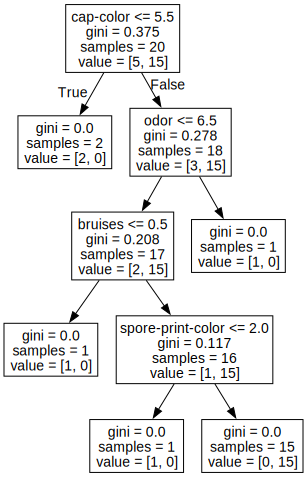

In [18]:
#Visualisation de l'arbre résultant
Source(export_graphviz(lore.xai_clf, out_file=None, feature_names=df_mushrooms.columns.drop('class')))

## Exercice 3: Expérimentations

#### Iris Dataset

In [19]:
from sklearn.datasets import load_iris
iris_data = load_iris()

In [20]:
iris_clf = DecisionTreeClassifier()
X = iris_data.data
y = iris_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

iris_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [21]:
lore_iris = LORELike(iris_clf, X_test)
lore_iris.lore(X_test[1], 10)

Rules used to predict sample 10:

decision node 0 : (test_set[10, 2] = 5.2) > 2.700000047683716)
decision node 2 : (test_set[10, 3] = 2.0) > 1.649999976158142)


Rules used to predict leaf 1:

decision node 0 : (X_test[10, 2] = 5.2) > 2.700000047683716)


Rules used to predict leaf 4:

decision node 0 : (X_test[10, 2] = 5.2) > 2.700000047683716)
decision node 2 : (X_test[10, 3] = 2.0) > 1.649999976158142)


Rules used to predict leaf 6:

decision node 0 : (X_test[10, 2] = 5.2) > 2.700000047683716)


Rules used to predict leaf 7:

decision node 0 : (X_test[10, 2] = 5.2) > 2.700000047683716)


Rules used to predict leaf 10:

decision node 0 : (X_test[10, 2] = 5.2) > 2.700000047683716)
decision node 2 : (X_test[10, 3] = 2.0) > 1.649999976158142)


Rules used to predict leaf 11:

decision node 0 : (X_test[10, 2] = 5.2) > 2.700000047683716)
decision node 2 : (X_test[10, 3] = 2.0) > 1.649999976158142)


Rules used to predict leaf 12:

decision node 0 : (X_test[10, 2] = 5.2) > 2.7000000476837

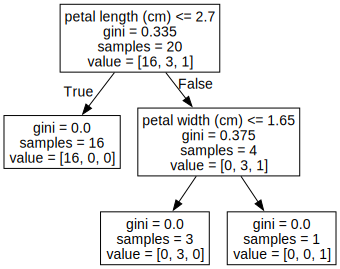

In [22]:
Source(export_graphviz(lore_iris.xai_clf, out_file=None, feature_names=iris_data.feature_names))

#### Breast Cancer

In [23]:
from sklearn.datasets import load_breast_cancer

data_bc = load_breast_cancer()
X, y = data_bc.data, data_bc.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
breast_clf = DecisionTreeClassifier()
breast_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [24]:
lore_bc = LORELike(breast_clf, X_test)
lore_bc.lore(X_test[8], 10)

Rules used to predict sample 10:

decision node 0 : (test_set[10, 12] = 1.778) <= 2.8574999570846558)


Rules used to predict leaf 6:

decision node 0 : (X_test[10, 12] = 1.778) <= 2.8574999570846558)


Rules used to predict leaf 8:

decision node 0 : (X_test[10, 12] = 1.778) <= 2.8574999570846558)


Rules used to predict leaf 9:

decision node 0 : (X_test[10, 12] = 1.778) <= 2.8574999570846558)


Rules used to predict leaf 11:

decision node 0 : (X_test[10, 12] = 1.778) <= 2.8574999570846558)


Rules used to predict leaf 13:

decision node 0 : (X_test[10, 12] = 1.778) <= 2.8574999570846558)


Rules used to predict leaf 14:

decision node 0 : (X_test[10, 12] = 1.778) <= 2.8574999570846558)


Rules used to predict leaf 17:

decision node 0 : (X_test[10, 12] = 1.778) <= 2.8574999570846558)


Rules used to predict leaf 18:

decision node 0 : (X_test[10, 12] = 1.778) <= 2.8574999570846558)


Rules used to predict leaf 19:

decision node 0 : (X_test[10, 12] = 1.778) <= 2.8574999570846558)



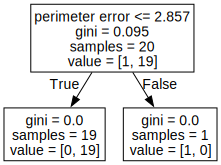

In [25]:
Source(export_graphviz(lore_bc.xai_clf, out_file=None, feature_names=data_bc.feature_names))